<a href="https://colab.research.google.com/github/shirsh12/Credit-Card-Fraud-detection-Model/blob/main/Credit_card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')
import os

In [6]:
data = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Cohort Nilgiri/Module 4/Week 3/Day 6/creditcard.csv')

In [7]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,Target
0,0.114697,0.796303,-0.149553,-0.823011,0.878763,-0.553152,0.939259,-0.108502,0.111137,-0.390521,-1.949546,-0.494436,-0.353696,0.158729,-0.267239,0.234802,-0.754936,-0.343012,0.312175,-0.042711,-0.335776,-0.807853,-0.055940,-1.025281,-0.369557,0.204653,0.242724,0.085713,0.89,0
1,-0.039318,0.495784,-0.810884,0.546693,1.986257,4.386342,-1.344891,-1.743736,-0.563103,-0.616315,-0.587786,0.317419,-0.408521,0.719639,0.226926,-0.296316,-0.040143,0.119177,1.057682,0.926255,-1.377003,-0.072200,-0.197573,1.014807,1.011293,-0.167684,0.113136,0.256836,85.00,0
2,2.275706,-1.531508,-1.021969,-1.602152,-1.220329,-0.462376,-1.196485,-0.147058,-0.950224,1.560463,-1.753256,-1.331010,-0.061941,-0.405532,0.048083,-0.307503,0.289363,0.189739,0.022546,-0.408289,-0.193271,-0.103533,0.150945,-0.811083,-0.197913,-0.128446,0.014197,-0.051289,42.70,0
3,1.940137,-0.357671,-1.210551,0.382523,0.050823,-0.171322,-0.109124,-0.002115,0.869258,-0.001965,0.607629,1.048673,-0.514821,0.329538,-1.041463,-0.498797,-0.276887,0.114245,0.379447,-0.199280,0.157994,0.650355,0.034206,0.739535,0.223605,-0.195509,-0.012791,-0.056841,29.99,0
4,1.081395,-0.502615,1.075887,-0.543359,-1.472946,-1.065484,-0.443231,-0.143374,1.659826,-1.131238,0.173132,1.430172,0.915609,-0.336588,1.140171,-0.653626,-0.016567,0.066287,0.242537,0.059880,0.224157,0.821209,-0.137223,0.986259,0.563228,-0.574206,0.089673,0.052036,68.00,0


In [8]:
data['Target'].value_counts()

0    56864
1       98
Name: Target, dtype: int64

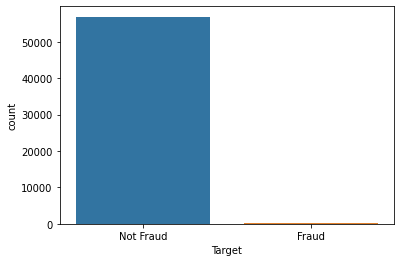

In [9]:
# visualize the target variable
g = sns.countplot(data['Target'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

## The Metric Trap

One of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy score can be misleading. In a dataset with highly unbalanced classes, the classifier will always “predict” the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one.

Let’s do this experiment, using simple XGBClassifier and no feature engineering:

In [10]:
# Creating the dataset with all independent variables
X = data.iloc[:,:-1]

# Creating the dataset with the dependent variable
Y = data.iloc[:,-1]

In [11]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

In [12]:
print("Distribution of classes of dependent variable in train :")
print(Y_train.value_counts())

print("\n Distribution of classes of dependent variable in test :")
print(Y_test.value_counts())

Distribution of classes of dependent variable in train :
0    45492
1       77
Name: Target, dtype: int64

 Distribution of classes of dependent variable in test :
0    11372
1       21
Name: Target, dtype: int64


In [13]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [14]:
y_pred = classifier.predict(X_test)

In [15]:
accuracy_score(y_pred, Y_test)

0.9987711752830686

In [16]:
confusion_matrix(y_pred, Y_test)

array([[11371,    13],
       [    1,     8]])

In [17]:
roc_auc_score(y_pred, Y_test)

0.9438734676348871

In [18]:
# Class count
class_count_0, class_count_1 = data['Target'].value_counts()

# Separate class
class_0 = data[data['Target'] == 0]
class_1 = data[data['Target'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (56864, 30)
class 1: (98, 30)


In [19]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(data.iloc[:,0:-1], data['Target'])

print('Original dataset shape:', len(data))
print('Resampled dataset shape', len(y_rus))

Original dataset shape: 56962
Resampled dataset shape 196


# **Synthetic Minority Oversampling Technique (SMOTE)**

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

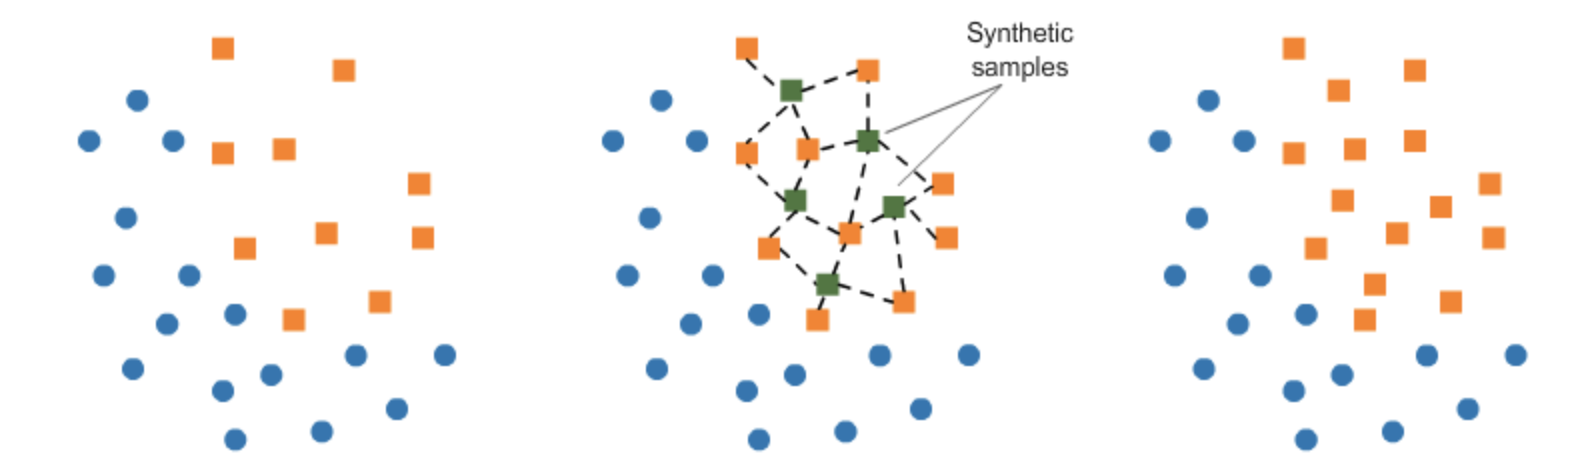

SMOTE algorithm works in 4 simple steps:

* Choose a minority class as the input vector
* Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
* Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
* Repeat the steps until data is balanced

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(data.iloc[:,0:-1], data['Target'])

print('Original dataset shape', len(data))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 56962
Resampled dataset shape 113728


# Choose the evaluation metric wisely

Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.

Metrics that can provide better insight are:

* **Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.
* **Precision**: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
* **Recall**: the number of true positives divided by the number of positive values in the test data. The recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
* **F1 Score**: the weighted average of precision and recall.
* **Area Under ROC Curve (AUC-ROC)**: AUC-ROC represents the likelihood of your model distinguishing observations from two classes. In other words, if you randomly select one observation from each class, what’s the probability that your model will be able to “rank” them correctly?

# Let's use SMOTE + Deep Neural Network to solve this!

In [21]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.2, random_state = 3)

In [22]:

# DNN
from tensorflow import keras

def get_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=[X_train.shape[-1]]),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(9, activation='softmax')
    ])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [23]:
# DNN (fit and validation)
import tensorflow as tf

batch_size = 512
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

model = get_model()
fit = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
178/178 [==============================] - 3s 15ms/step - loss: 0.8299 - accuracy: 0.7714 - val_loss: 0.0828 - val_accuracy: 0.9800
Epoch 2/20
178/178 [==============================] - 2s 14ms/step - loss: 0.1160 - accuracy: 0.9587 - val_loss: 0.0366 - val_accuracy: 0.9887
Epoch 3/20
178/178 [==============================] - 2s 13ms/step - loss: 0.0743 - accuracy: 0.9759 - val_loss: 0.0319 - val_accuracy: 0.9883
Epoch 4/20
178/178 [==============================] - 2s 13ms/step - loss: 0.0395 - accuracy: 0.9843 - val_loss: 0.0281 - val_accuracy: 0.9859
Epoch 5/20
178/178 [==============================] - 2s 14ms/step - loss: 0.0503 - accuracy: 0.9827 - val_loss: 0.0275 - val_accuracy: 0.9938
Epoch 6/20
178/178 [==============================] - 2s 13ms/step - loss: 0.0297 - accuracy: 0.9888 - val_loss: 0.0155 - val_accuracy: 0.9954
Epoch 7/20
178/178 [==============================] - 2s 13ms/step - loss: 0.0236 - accuracy: 0.9913 - val_loss: 0.0386 - val_accuracy: 0.9792

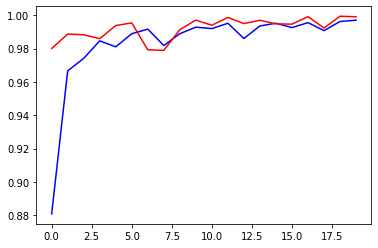

In [24]:
import matplotlib.pyplot as plt

plt.plot(fit.history['accuracy'], color='blue')
plt.plot(fit.history['val_accuracy'], color='red')
plt.show()

In [25]:
y_pred_nn = model.predict_classes(val_ds)

In [26]:
print('ROCAUC score:', roc_auc_score(y_test, y_pred_nn))
print('Accuracy score:', accuracy_score(y_test, y_pred_nn))

ROCAUC score: 0.9990856048071062
Accuracy score: 0.9990767607491428


In [27]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,y_pred_nn))


[[11462    21]
 [    0 11263]]


In [28]:
print(classification_report(y_test,y_pred_nn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11483
           1       1.00      1.00      1.00     11263

    accuracy                           1.00     22746
   macro avg       1.00      1.00      1.00     22746
weighted avg       1.00      1.00      1.00     22746



# That looks great! Fraudsters, here I come!